# 测量偏差
成人收入数据集的公平性分析。

数据集：https://archive.ics.uci.edu/ml/datasets/adult

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

import shap
import os

data_path = os.environ.get('pub_data')

In [205]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

#Load dataset
df = pd.read_csv(data_path + 'adult_all.csv', names=names, na_values='?')
df = df.dropna()
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

print(len(df))
df.head(10)

32561


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [206]:
# Snap shot of dataset
df[['age','education-num','marital-status','occupation',
    'hours-per-week','native-country',
    'race','sex','y']].head(10)

,age,education-num,marital-status,occupation,hours-per-week,native-country,race,sex,y
0,39,13,Never-married,Adm-clerical,40,United-States,White,Male,<=50K
1,50,13,Married-civ-spouse,Exec-managerial,13,United-States,White,Male,<=50K
2,38,9,Divorced,Handlers-cleaners,40,United-States,White,Male,<=50K
3,53,7,Married-civ-spouse,Handlers-cleaners,40,United-States,Black,Male,<=50K
4,28,13,Married-civ-spouse,Prof-specialty,40,Cuba,Black,Female,<=50K
5,37,14,Married-civ-spouse,Exec-managerial,40,United-States,White,Female,<=50K
6,49,5,Married-spouse-absent,Other-service,16,Jamaica,Black,Female,<=50K
7,52,9,Married-civ-spouse,Exec-managerial,45,United-States,White,Male,>50K
8,31,14,Never-married,Prof-specialty,50,United-States,White,Female,>50K
9,42,13,Married-civ-spouse,Exec-managerial,40,United-States,White,Male,>50K


## Exploratory analysis

### Unbalanced datasets

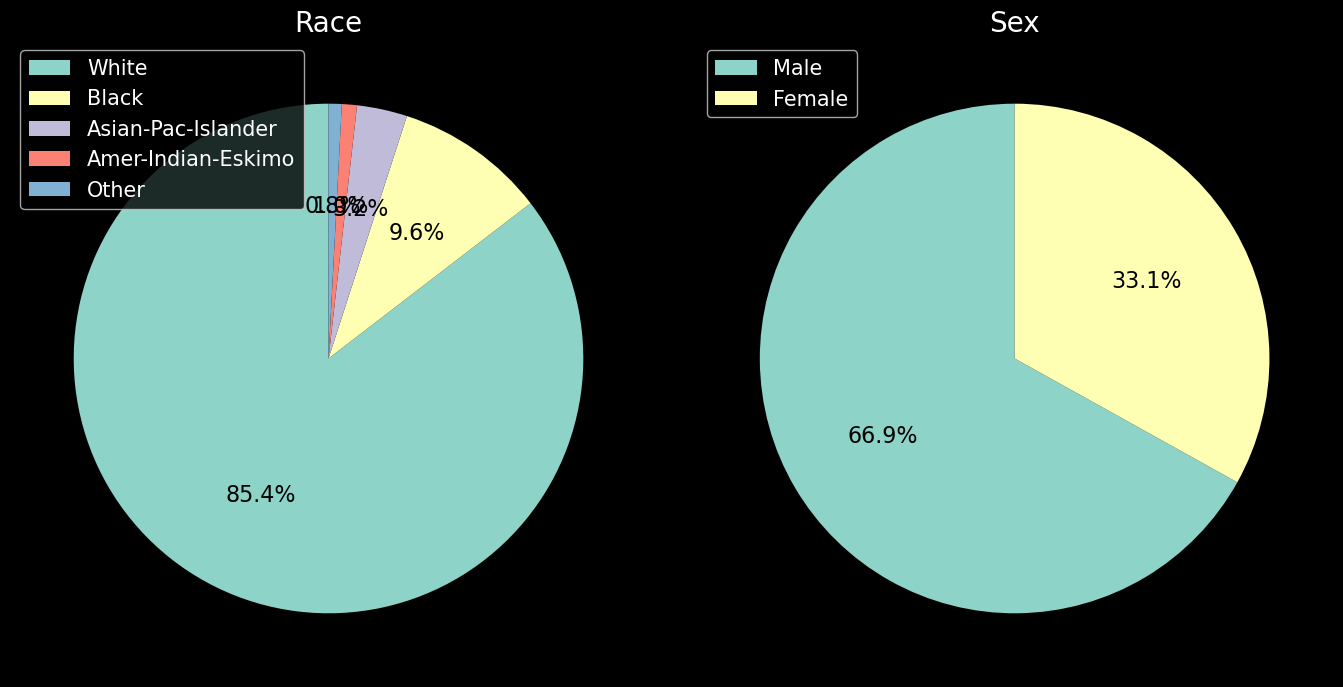

In [207]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

# Plot breakdown by race
counts = df['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 16, 'color': 'black'})
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

# Plot breakdown by sex
counts = df['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 16, 'color': 'black'})
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)


plt.tight_layout(pad=2)
plt.savefig('../../figures/unbalnced_datsets.png', format='png', dpi=150)

### Defining protected features

In [208]:
df_fair = df[['race','sex']].copy()

# Define protected features 
df_fair['priv_race'] = df_fair['race'].apply(lambda x: 1 if x=='White' else 0)
df_fair['priv_sex'] = df_fair['sex'].apply(lambda x: 1 if x=='Male' else 0)

# Define target variable 
df_fair['y'] = df['y'].apply(lambda x: 1 if x=='>50K' else 0)

df_fair.head()

,race,sex,priv_race,priv_sex,y
0,White,Male,1,1,0
1,White,Male,1,1,0
2,White,Male,1,1,0
3,Black,Male,0,1,0
4,Black,Female,0,0,0


### Prevelance

In [209]:
# Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.2408095574460244
priv_race
0    0.152582
1    0.255860
Name: y, dtype: float64
priv_sex
0    0.109461
1    0.305737
Name: y, dtype: float64
priv_race  priv_sex
0          0           0.070925
           1           0.219037
1          0           0.118954
           1           0.317565
Name: y, dtype: float64


### Proxy Variable

In [210]:
# Target variable 
y = df['y'].apply(lambda x:1 if x=='>50K' else 0)

# Model features
X = df[['age','education-num','hours-per-week']].copy()
X['marital-status'] = df['marital-status'].apply(lambda x:1 if x=='Married-civ-spouse' else 0)
X['native-country'] = df['native-country'].apply(lambda x:1 if x=='United-States' else 0) 

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4, '?':-1}

X['occupation'] = [occ_groups[x] if x in occ_groups else -1 for x in df['occupation']]
X.head()

,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


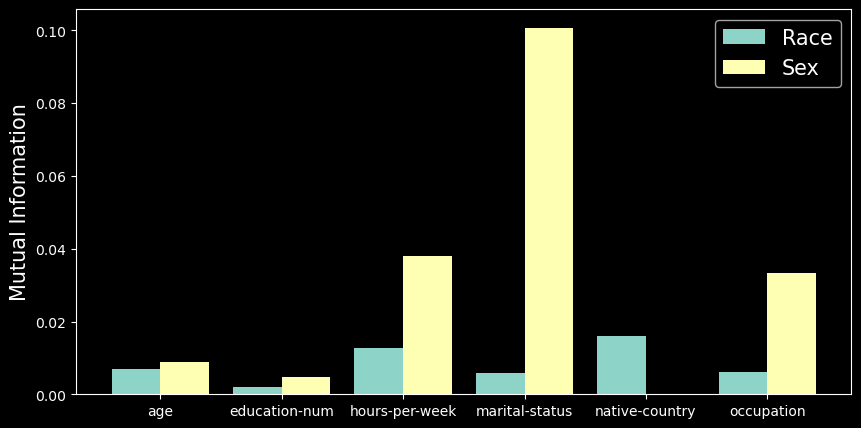

In [211]:
# Mutual information 

# Calcualte mutual information
mut_race = mutual_info_classif(X,df_fair['priv_race'],discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])


# Plot mutual information 
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)

plt.savefig('../../figures/Mutual_information.png', format='png', dpi=100)

In [161]:
# Feature importance race

# Get balanced sample 
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = pd.concat([y_race_0,y_race_1])

X_race = X.loc[y_race.index]

# Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

# Calculate accuracy 
acc_race = accuracy_score(y_race, y_pred)

# Get feature importance 
fi_race = model.get_booster().get_score(importance_type='weight')


# Output results 
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

0.7569020021074816
[[3614 1131]
 [1176 3569]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      4745
           1       0.76      0.75      0.76      4745

    accuracy                           0.76      9490
   macro avg       0.76      0.76      0.76      9490
weighted avg       0.76      0.76      0.76      9490



In [163]:
# Feature importance sex

# Get balanced sample 
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = pd.concat([y_sex_0, y_sex_1])
# y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

# Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

# Calculate accuracy 
acc_sex = accuracy_score(y_sex, y_pred)

# Get feature importance 
fi_sex = model.get_booster().get_score(importance_type='weight')

# Output results 
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

0.7942159502367468
[[9135 1636]
 [2797 7974]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.80     10771
           1       0.83      0.74      0.78     10771

    accuracy                           0.79     21542
   macro avg       0.80      0.79      0.79     21542
weighted avg       0.80      0.79      0.79     21542



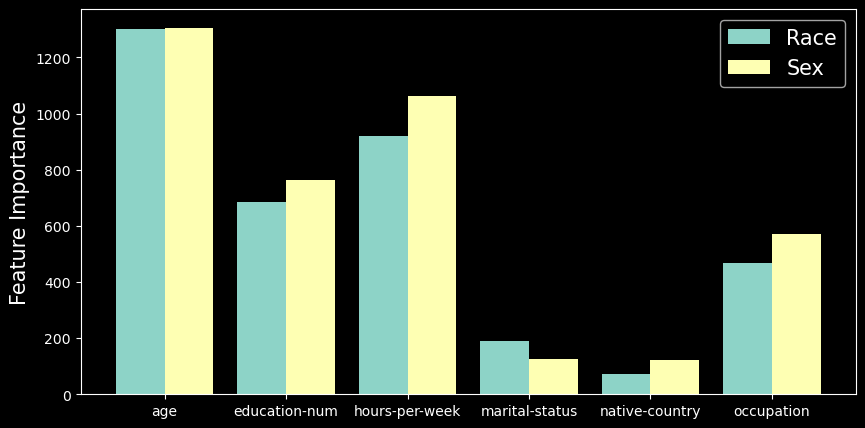

In [188]:
# Plot feature importance
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']

fi_race= [fi_race[labels.index(l)] for l in labels]
fi_sex= [fi_sex[labels.index(l)] for l in labels]

x = np.arange(len(labels)) 
width = 0.4

plt.bar(x-width/2, height=fi_race, width=width, label='Race')
plt.bar(x+width/2, height=fi_sex, width=width, label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Feature Importance',size=15)
plt.xticks(ticks=x, labels=labels)

plt.savefig('../../figures/Feature Importance.png', format='png', dpi=100)

## Measuring fairness

### Modelling

In [189]:
# Train model 
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

[[23030  1690]
 [ 3085  4756]]
0.8533521697736556
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     24720
           1       0.74      0.61      0.67      7841

    accuracy                           0.85     32561
   macro avg       0.81      0.77      0.79     32561
weighted avg       0.85      0.85      0.85     32561



## Feasures of Fairness

In [190]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    # Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN
    
    # Overall accuracy
    ACC = (TP+TN)/N
    
    # True positive rate
    TPR = TP/(TP+FN)
    
    # False positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Percentage predicted as positive
    PPP = (TP + FP)/N
    
    return np.array([ACC, TPR, FPR, FNR, PPP])  
    

In [191]:
# Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

# Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

[0.84634743 0.61556836 0.07430311 0.38443164 0.2127912 ]
[0.89441517 0.5179558  0.03780154 0.4820442  0.11106428]
[1.05679435 0.84142694 0.5087478  1.25391395 0.52194019]


In [192]:
# Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


# Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.8179899  0.63464425 0.10126917 0.36535575 0.26434144]
[0.92489091 0.44783715 0.01647206 0.55216285 0.06368954]
[1.13068744 0.70565068 0.16265622 1.51130193 0.24093663]


## Additional analysis

In [193]:
df_fair['marital-status'] = X['marital-status']

#Calculate figures
count_ms = df_fair.groupby(['priv_sex','marital-status'])['priv_sex'].count()
prev_ms = df_fair.groupby(['marital-status'])['y'].mean()
prev_sex = df_fair.groupby(['priv_sex'])['y'].mean()

print(count_ms)
print(prev_ms)
print(prev_sex)

priv_sex  marital-status
0         0                  9114
          1                  1657
1         0                  8471
          1                 13319
Name: priv_sex, dtype: int64
marital-status
0    0.065340
1    0.446848
Name: y, dtype: float64
priv_sex
0    0.109461
1    0.305737
Name: y, dtype: float64


## Archive

In [194]:
import numpy as np
shape, scale = 2., 2.  # mean=4, std=2*sqrt(2)
r = np.random.gamma(3, 0.5, 1000)
r = (r-min(r))/(max(r)-min(r))
r = 16 + 60*r

nr = np.random.gamma(5, 1, 5000)
nr = (nr-min(nr))/(max(nr)-min(nr))
nr = 18 + 62*nr

In [195]:
avg_r = np.mean(r)
avg_nr = np.mean(nr)
avg_t = np.mean([*r,*nr])
print(avg_t,avg_nr,avg_r)

31.937245509805322 33.04552606619293 26.395842727867315


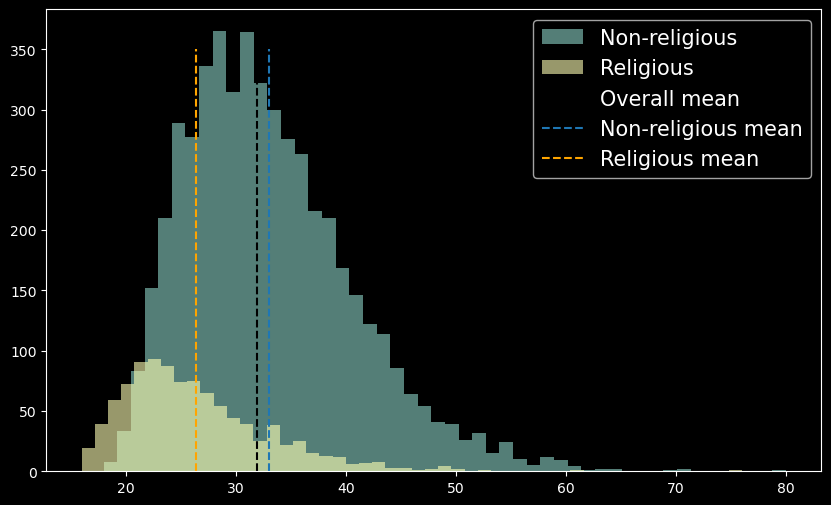

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(nr, 50,label='Non-religious',alpha = 0.6)
plt.hist(r, 50,label='Religious',alpha = 0.6)

plt.vlines(x=avg_t,ymin=0,ymax=350,colors='Black',linestyles='--', label= 'Overall mean')
plt.vlines(x=avg_nr,ymin=0,ymax=350,colors='#1F77B4',linestyles='--', label= 'Non-religious mean')
plt.vlines(x=avg_r,ymin=0,ymax=350,colors='Orange',linestyles='--', label= 'Religious mean')

plt.legend(prop={'size': 15})
plt.savefig('../../figures/skew_example.png', format='png', dpi=150)